In [84]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

import xlrd
import seaborn as sns
import warnings

#This will make sure warning messages don't pop up when you run blocks
warnings.filterwarnings('ignore') 

In [85]:
#In this block, we are working directly with all the nyc rolling sales data for the past year

nyc_df = pd.read_csv('nyc-rolling-sales.csv')
nyc_df.drop(['Unnamed: 0'], axis = 1, inplace = True) #extra column?

#Check for duplicates, or else that will introduce unnecessary bias into our model

print('The length of our original dataset is', len(nyc_df))
print('The amount of duplicates we have is', len(nyc_df[nyc_df.duplicated(nyc_df.columns)]))
nyc_df.drop_duplicates(keep = 'last', inplace = True)
print('We are now left with', len(nyc_df))

print(nyc_df.shape)

#sum(nyc_df.duplicated(nyc_df.columns))

#Pre-processing for column(s) EASE-MENT, APARTMENT_NUMBER, ADDRESS: 
#EASE-MENT: empty column, so drop it, 
#APARTMENT_NUMBER: making assumption that this does matter much, that most apartments at address cost around the same
#ADDRESS: already other features such as borough, neighborhood, building class, etc, so redundant feature
# ^ will be highly correlated w/ such features
#BUILDING_CLASS_AT_PRESENT: seems like a redundant feature, because we already have BUILDING_CLASS_AT_TIME_OF_SALE
#TAX_CLASS_AT_PRESENT: like above feature, redundant
#ZIP_CODE: seems redundant to have when we already have BLOCK and LOT

print(len(nyc_df['ZIP_CODE'].unique()))

cols_to_drop = [
    'EASE-MENT',
    'APARTMENT_NUMBER',
    'ADDRESS',
    'BUILDING_CLASS_AT_PRESENT',
    'TAX_CLASS_AT_PRESENT',
    'ZIP_CODE',
    'LOT',
    'BLOCK'
]

nyc_df.drop(cols_to_drop, axis = 1, inplace = True)

#nyc_df

The length of our original dataset is 84548
The amount of duplicates we have is 765
We are now left with 83783
(83783, 21)
186


In [86]:
#Preprocessing step for NEIGHBORHOOD

print('There are', len(nyc_df['NEIGHBORHOOD'].unique()), ' unique neighborhoods')
#print('There are', len(nyc_df['BLOCK'].unique()), ' unique blocks')
#print('There are', len(nyc_df['LOT'].unique()), ' unique lots')

#There are 254 neighborhoods, so if we were to one hot encode this feature later, we'd add at least 253 more features
#This may or may not make a huge impact in our model, so we will first see the results without this feature
#Same logic for the features BLOCK and LOT

#nyc_df.drop(['NEIGHBORHOOD', 'BLOCK', 'LOT'], axis = 1, inplace = True)
#nyc_df.drop(['NEIGHBORHOOD'], axis = 1, inplace = True)

#Preprocessing step for SALE_DATE: we can assume that the time sold anywhere over the past 11 months will not make too
#much of an impact on our model since that is a short time frame, 
#let's start off by keeping it for one-hot encoding and only having in the form of "YYYY-MM", so it won't add too
#many dummy features and to keep it generalized

#nyc_df.drop(['SALE_DATE'], axis = 1, inplace = True)
nyc_df['SALE_DATE'] = nyc_df['SALE_DATE'].str[:7]

#Preprocessing step for BUILDING_CLASS_CATEGORY: may not make a difference but just keep the number
nyc_df['BUILDING_CLASS_CATEGORY'] = nyc_df['BUILDING_CLASS_CATEGORY'].str[:2]
nyc_df['BUILDING_CLASS_CATEGORY'][nyc_df['BUILDING_CLASS_CATEGORY'].str[0] == '0'] = nyc_df['BUILDING_CLASS_CATEGORY'][nyc_df['BUILDING_CLASS_CATEGORY'].str[0] == '0'].str[1]


There are 254  unique neighborhoods


In [87]:
#Pre-processing step for TOTAL_UNITS: drop all rows that have 0 units (because all housing needs to have at 
#least one unit, or else it wouldn't make sense, safe to just get rid of these rows for now) or any outlier data

#We will assume that since there is a lot of data where the total units is > 30, that having housing with
#total units more than 30 is not outlier data. We will modify later as we see fit

nyc_df[['TOTAL_UNITS', 'SALE_PRICE']].groupby(['TOTAL_UNITS'], as_index = False).count().sort_values(
    by = 'SALE_PRICE', ascending = False)

nyc_df = nyc_df[(nyc_df['TOTAL_UNITS'] != 0)]
#len(nyc_df)

#May drop TOTAL_UNITS later, more useful information in residential & commercial units separately, redundant




In [88]:
#Preprocessing for SALE_PRICE
#Filling in all the blanks with NaN, so we can use isnull(), notnull(), etc

blank = nyc_df['SALE_PRICE'].iloc[1]
nyc_df['SALE_PRICE'][nyc_df['SALE_PRICE'] == blank] = np.nan

#Does not make sense to have housing that sale prices of 0, so will just get rid of them, as we do not know the
#exact reason why they had a value of '0' and not '-', to begin with

#len(nyc_df[nyc_df['SALE_PRICE'] == '0'])
nyc_df = nyc_df[nyc_df['SALE_PRICE'] != '0']

print('nyc_df currently has', len(nyc_df.columns))

#This will turn nyc_df into a version of itself where the known prices are known (so they don't have "-")
#We will save the unknown values in another dataframe

nyc_df_unknown = nyc_df[nyc_df['SALE_PRICE'].isnull()]
nyc_df = nyc_df[nyc_df['SALE_PRICE'].notnull()]




nyc_df currently has 13


In [89]:
#Preprocessing for LAND_SQUARE_FEET, GROSS_SQUARE_FEET
#Impute the missing values with the mean for each borough, for the time being

nyc_df['LAND_SQUARE_FEET'][nyc_df['LAND_SQUARE_FEET'] == blank] = np.nan
nyc_df['GROSS_SQUARE_FEET'][nyc_df['GROSS_SQUARE_FEET'] == blank] = np.nan
nyc_df_unknown['LAND_SQUARE_FEET'][nyc_df_unknown['LAND_SQUARE_FEET'] == blank] = np.nan
nyc_df_unknown['GROSS_SQUARE_FEET'][nyc_df_unknown['GROSS_SQUARE_FEET'] == blank] = np.nan

nyc_df['LAND_SQUARE_FEET'] = nyc_df['LAND_SQUARE_FEET'].astype(float)
nyc_df['GROSS_SQUARE_FEET'] = nyc_df['GROSS_SQUARE_FEET'].astype(float)
nyc_df_unknown['LAND_SQUARE_FEET'] = nyc_df_unknown['LAND_SQUARE_FEET'].astype(float)
nyc_df_unknown['GROSS_SQUARE_FEET'] = nyc_df_unknown['GROSS_SQUARE_FEET'].astype(float)

#missing = nyc_df.isnull().sum() / len(nyc_df)
#missing = missing[missing > 0]
#missing.sort_values(inplace = True)
#missing

#Loop logic will replace null values with the mean housing price for each borough
for borough in nyc_df.BOROUGH.unique():
    borough_lsf = nyc_df['LAND_SQUARE_FEET'][nyc_df['BOROUGH'] == borough]
    borough_gsf = nyc_df['GROSS_SQUARE_FEET'][nyc_df['BOROUGH'] == borough]
    
    
    print('The number of missing land square feet samples for borough', borough, ' is ', 
          (borough_lsf.isnull().sum(),
          '/', (nyc_df.BOROUGH == borough).sum()))
    print('The number of missing gross square feet samples for borough', borough, 'is ', 
          (borough_gsf.isnull().sum(),
          '/', (nyc_df.BOROUGH == borough).sum()))
    print('The number of data points that are missing both are', 
         (borough_lsf.isnull() & borough_gsf.isnull()).sum())
    
    borough_district = nyc_df[nyc_df['BOROUGH'] == borough]
    
    mean_lsf = borough_district['LAND_SQUARE_FEET'][borough_district['LAND_SQUARE_FEET'].notnull()].sum() / len(borough_district['LAND_SQUARE_FEET'][borough_district['LAND_SQUARE_FEET'].notnull()])
    mean_gsf = borough_district['GROSS_SQUARE_FEET'][borough_district['GROSS_SQUARE_FEET'].notnull()].sum() / len(borough_district['GROSS_SQUARE_FEET'][borough_district['GROSS_SQUARE_FEET'].notnull()])
    print('The mean_lsf and mean_gsf are respectively ', mean_lsf, mean_gsf)
    
    nyc_df_borough_lsf = nyc_df['LAND_SQUARE_FEET'][nyc_df['BOROUGH'] == borough]
    nyc_df_borough_lsf[nyc_df_borough_lsf.isnull()] = mean_lsf
    nyc_df_borough_gsf = nyc_df['GROSS_SQUARE_FEET'][nyc_df['BOROUGH'] == borough]
    nyc_df_borough_gsf[nyc_df_borough_gsf.isnull()] = mean_gsf
    nyc_df['LAND_SQUARE_FEET'][nyc_df['BOROUGH'] == borough] = nyc_df_borough_lsf
    nyc_df['GROSS_SQUARE_FEET'][nyc_df['BOROUGH'] == borough] = nyc_df_borough_gsf
    
    #For unknown dataset
    
    nyc_df_unknown['LAND_SQUARE_FEET'][(nyc_df_unknown['BOROUGH'] == borough) & (nyc_df_unknown['LAND_SQUARE_FEET'].isnull())] = mean_lsf
    nyc_df_unknown['GROSS_SQUARE_FEET'][(nyc_df_unknown['BOROUGH'] == borough) & (nyc_df_unknown['GROSS_SQUARE_FEET'].isnull())] = mean_gsf
#nyc_df


The number of missing land square feet samples for borough 1  is  (6177, '/', 7145)
The number of missing gross square feet samples for borough 1 is  (6178, '/', 7145)
The number of data points that are missing both are 6173
The mean_lsf and mean_gsf are respectively  5727.018595041322 35302.41261633919
The number of missing land square feet samples for borough 2  is  (0, '/', 3978)
The number of missing gross square feet samples for borough 2 is  (0, '/', 3978)
The number of data points that are missing both are 0
The mean_lsf and mean_gsf are respectively  4040.15987933635 4904.421317244846
The number of missing land square feet samples for borough 3  is  (0, '/', 12709)
The number of missing gross square feet samples for borough 3 is  (0, '/', 12709)
The number of data points that are missing both are 0
The mean_lsf and mean_gsf are respectively  2043.6359272956172 2498.0725470139273
The number of missing land square feet samples for borough 4  is  (2383, '/', 13457)
The number of m

5 Categorical features: Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'],
      dtype='object')
8 Numerical features: Index(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE'],
      dtype='object')


,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
RESIDENTIAL_UNITS,1.000000,0.012859,0.826395,0.497188,0.649491,0.018536,0.029184,0.136351
COMMERCIAL_UNITS,0.012859,1.000000,0.573625,0.052984,0.051011,0.004271,0.050489,0.045537
TOTAL_UNITS,0.826395,0.573625,1.000000,0.437155,0.560997,0.016967,0.055230,0.137398
LAND_SQUARE_FEET,0.497188,0.052984,0.437155,1.000000,0.629093,0.008491,0.068406,0.043656
GROSS_SQUARE_FEET,0.649491,0.051011,0.560997,0.629093,1.000000,-0.059513,0.236842,0.485705
YEAR_BUILT,0.018536,0.004271,0.016967,0.008491,-0.059513,1.000000,-0.173426,0.007188
TAX_CLASS_AT_TIME_OF_SALE,0.029184,0.050489,0.055230,0.068406,0.236842,-0.173426,1.000000,0.126027
SALE_PRICE,0.136351,0.045537,0.137398,0.043656,0.485705,0.007188,0.126027,1.000000


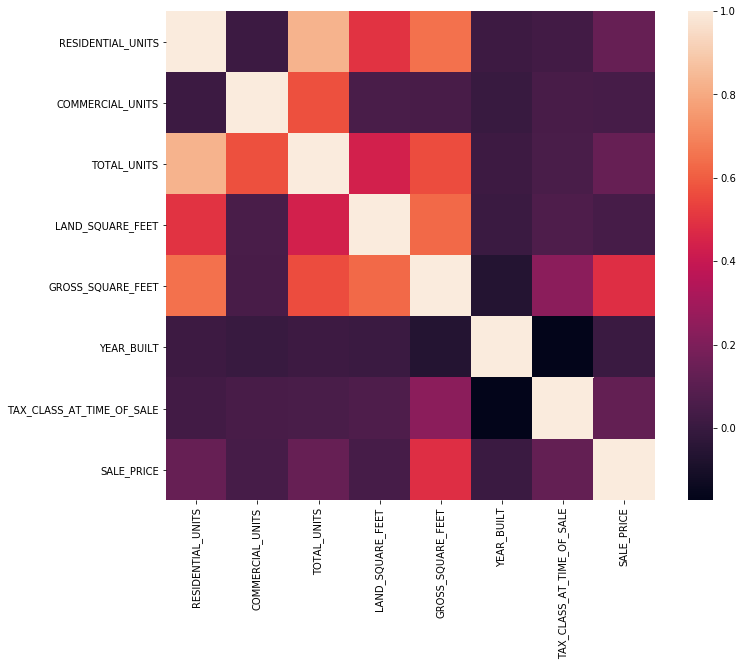

In [90]:
#Preprocessing steps for rest of the features, converting them to float from object or vice versa as per 
#definitions of numerical and categorical features

#nyc_df['BLOCK'] = nyc_df['BLOCK'].astype(float)
#nyc_df['LOT'] = nyc_df['LOT'].astype(float)
#nyc_df['ZIP_CODE'] = nyc_df['ZIP_CODE'].apply(str)
#nyc_df['TAX_CLASS_AT_TIME_OF_SALE'] = nyc_df['TAX_CLASS_AT_TIME_OF_SALE'].apply(str)
nyc_df['BOROUGH'] = nyc_df['BOROUGH'].apply(str)
nyc_df['SALE_PRICE'] = nyc_df['SALE_PRICE'].astype(float)
nyc_df_unknown['BOROUGH'] = nyc_df_unknown['BOROUGH'].apply(str)


#Print categorical and numerical feature information
print(len(nyc_df.select_dtypes(include = ['object']).columns), 'Categorical features:', nyc_df.select_dtypes(include = ['object']).columns)
print(len(nyc_df.select_dtypes(include = ['int64','float64']).columns), 'Numerical features:', nyc_df.select_dtypes(include = ['int64', 'float64']).columns)

#Analyze the correlation between the numerical features (specifically each feature w/ the SALE_PRICE)
corrmat = nyc_df.corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 1, square = True)

corrmat['SALE_PRICE'].sort_values(ascending=False)
corrmat

In [91]:
print(len(nyc_df.select_dtypes(include = ['int64','float64']).columns), 'Numerical features:', nyc_df.select_dtypes(include = ['int64', 'float64']).columns)

sp = 'SALE_PRICE'
ru = 'RESIDENTIAL_UNITS'
cu = 'COMMERCIAL_UNITS'
tu = 'TOTAL_UNITS'
lsf = 'LAND_SQUARE_FEET'
gsf = 'GROSS_SQUARE_FEET'
yb = 'YEAR_BUILT'
tc = 'TAX_CLASS_AT_TIME_OF_SALE'

8 Numerical features: Index(['RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_PRICE'],
      dtype='object')


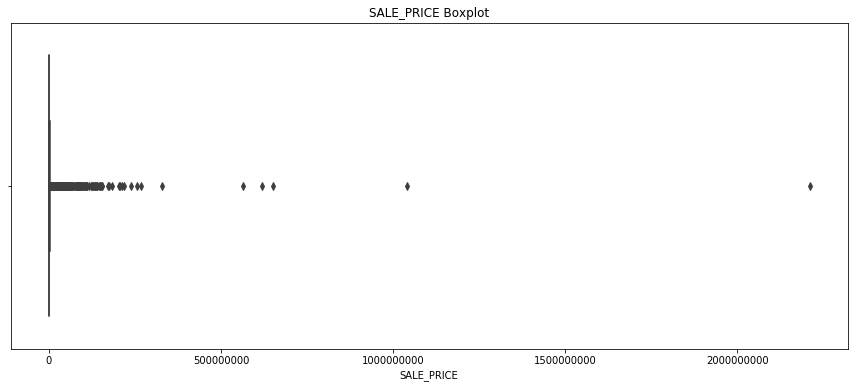

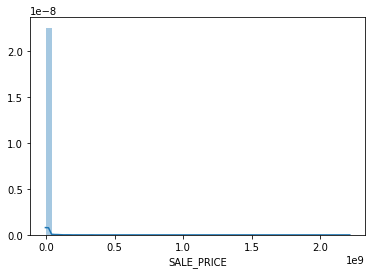

In [62]:
#Analyzing SALE_PRICE

plt.figure(figsize = (15, 6))

sns.boxplot(x = sp, data = nyc_df)
plt.ticklabel_format(style = 'plain', axis = 'x')
plt.title('SALE_PRICE Boxplot')
plt.show()

sns.distplot(nyc_df[sp])

nyc_df_sp = nyc_df


There are 2508 samples past the upper bound
The initial distribution has a skew value of 1.988862497435504
The log distribution has a skew value of -0.06621838778797143


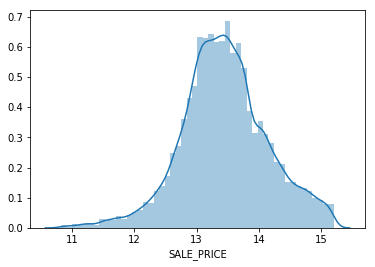

In [63]:
#Since we can barely see the distplot, we need to filter the dataset more

#If we look at SALE_PRICE > upper_bound, and also the outliers where SALE_PRICE < lower_bound
#Simply by playing around with the two variables, we can see the different skew values as well as the 
#log transformation results and see which numbers have a good chance of giving us favorable results, later

upper_bound = 4000000
lower_bound = 50000

nyc_df_sp = nyc_df[(nyc_df[sp] < upper_bound) & (nyc_df[sp] > lower_bound)]
print('There are', len(nyc_df[(nyc_df[sp] > upper_bound)]), 'samples past the upper bound')

#sns.distplot(nyc_df_sp[sp])
print('The initial distribution has a skew value of', nyc_df_sp[sp].skew())

#We observe that the distribution is heavily right-skewed, so we can perform a logarithmic transformation to try to
#normalize the distribution

#Keep playing around with the above variables to try to get the log distribution be non-skewed
#A lower bound of 50000 gave us a skew value that was nonnegative and close to 0

log_distribution = np.log(nyc_df_sp[sp])
print('The log distribution has a skew value of', log_distribution.skew())

sns.distplot(log_distribution)

nyc_df = nyc_df_sp

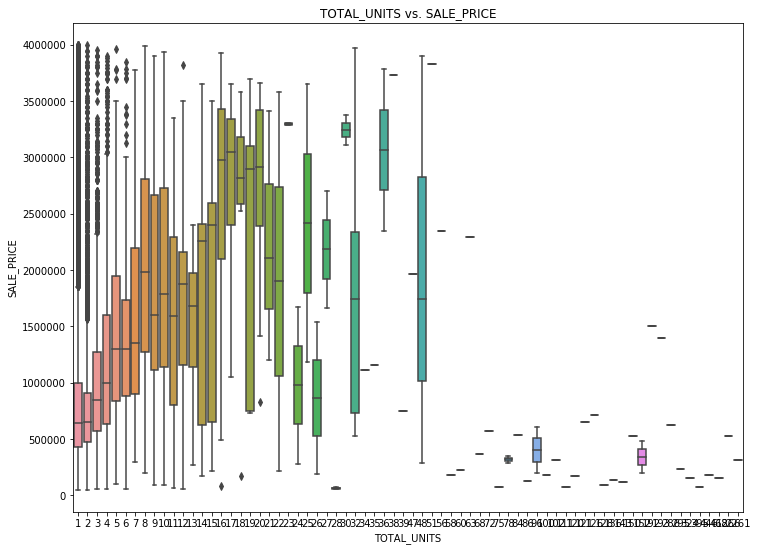

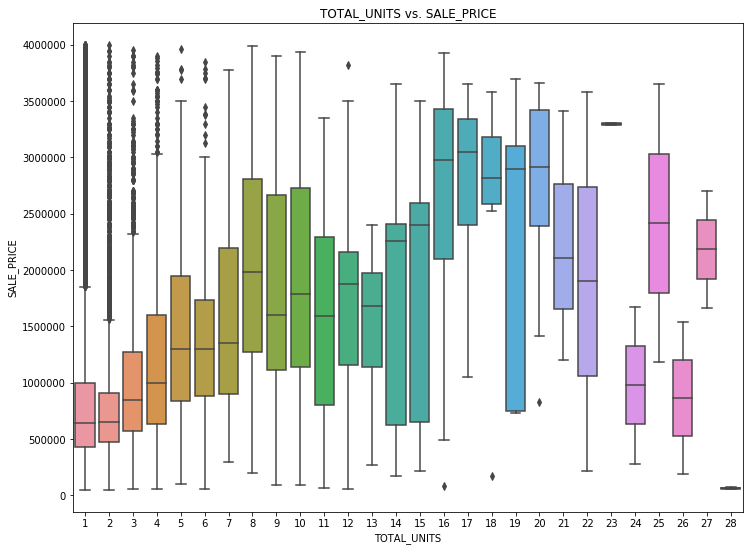

In [64]:
#Analyzing the statistics for TOTAL_UNITS

plt.figure(figsize = (12, 9))
sns.boxplot(x = tu, y = sp, data = nyc_df)
plt.title('TOTAL_UNITS vs. SALE_PRICE')

#Check the counts of TOTAL_UNITS along w/ looking at the boxplot, and filter accordingly

nyc_df[['TOTAL_UNITS', 'SALE_PRICE']].groupby(['TOTAL_UNITS'], as_index = False).count().sort_values(
    by = 'SALE_PRICE', ascending = False)

nyc_df = nyc_df[nyc_df[tu] < 50]

#We see that total units from between 30 to 50 don't follow expected behavior, so we can reasonably void them 
#as outliers

nyc_df = nyc_df[nyc_df[tu] < 30]

plt.figure(figsize = (12, 9))
sns.boxplot(x = tu, y = sp, data = nyc_df)
plt.title('TOTAL_UNITS vs. SALE_PRICE')

nyc_df.drop(['TOTAL_UNITS'], axis = 1, inplace = True)

Text(0.5, 1.0, 'RESIDENTIAL_UNITS vs. SALE_PRICE')

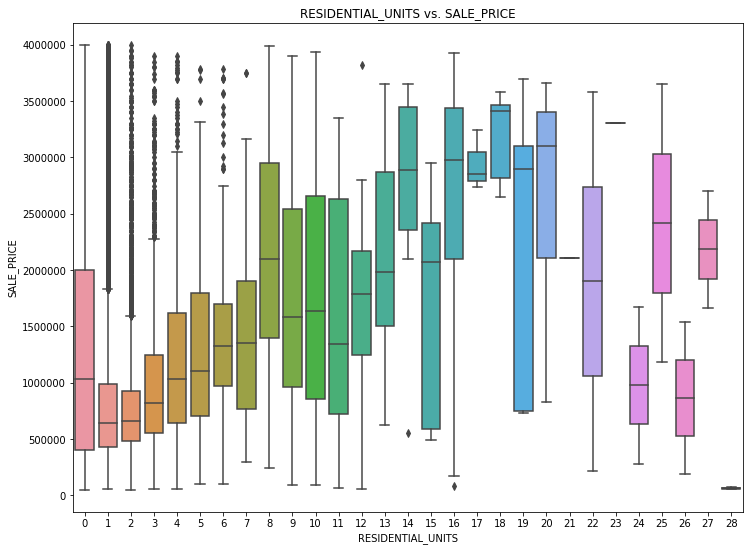

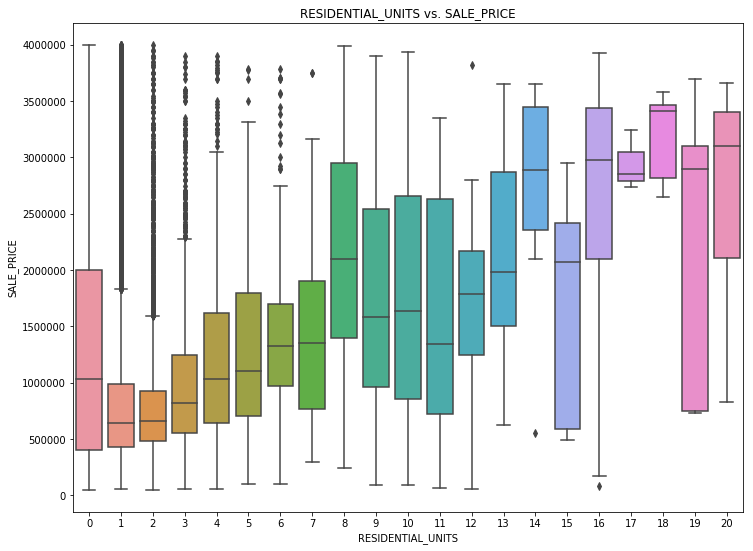

In [65]:
#Analyzing the statistics for RESIDENTIAL_UNITS, looks fine

plt.figure(figsize = (12, 9))
sns.boxplot(x = ru, y = sp, data = nyc_df)
plt.title('RESIDENTIAL_UNITS vs. SALE_PRICE')

#SIDE NOTE: RESIDENTIAL_UNITS seems to be correlated w/ TOTAL_UNITS to some extent, may end up removing
#TOTAL_UNITS later

nyc_df = nyc_df[nyc_df[ru] < 21]

plt.figure(figsize = (12, 9))
sns.boxplot(x = ru, y = sp, data = nyc_df)
plt.title('RESIDENTIAL_UNITS vs. SALE_PRICE')

Text(0.5, 1.0, 'COMMERCIAL_UNITS vs. SALE_PRICE')

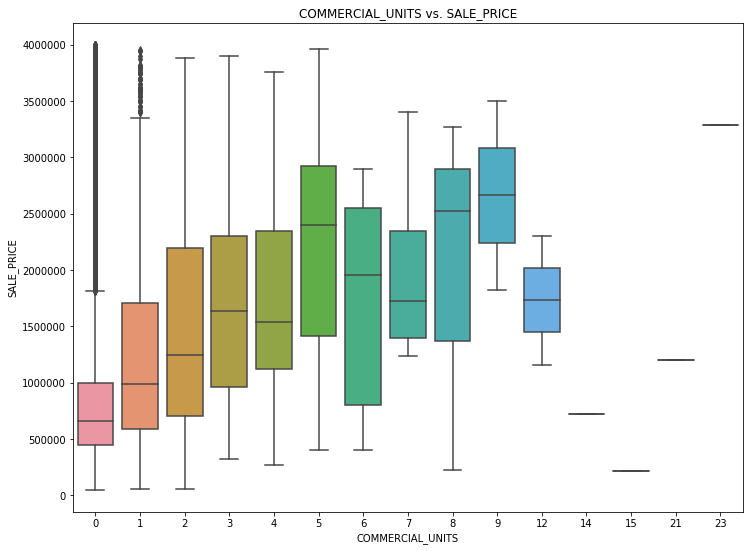

In [66]:
#Analyzing the statistics for COMMERCIAL_UNITS, looks fine

plt.figure(figsize = (12, 9))
sns.boxplot(x = cu, y = sp, data = nyc_df)
plt.title('COMMERCIAL_UNITS vs. SALE_PRICE')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139]),
 <a list of 140 Text xticklabel objects>)

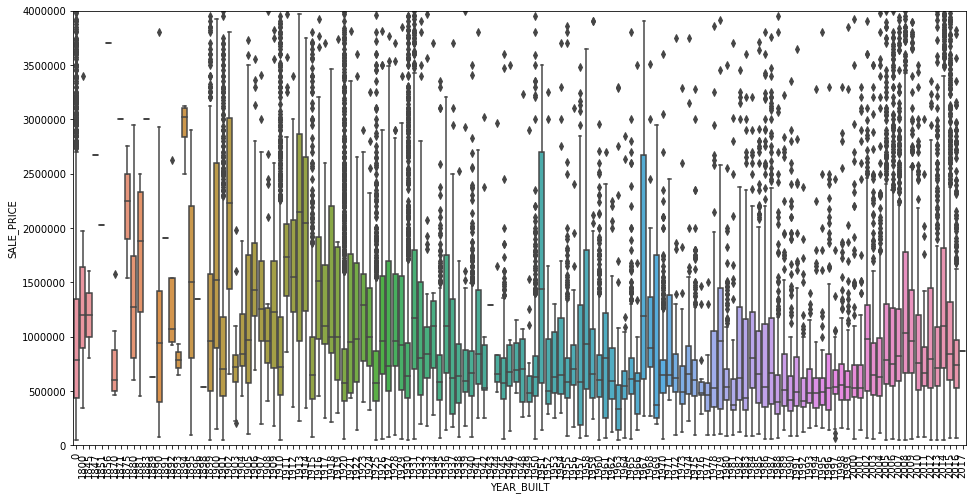

In [67]:
#Year Built vs. Sale Price

data_yb = pd.concat([nyc_df[sp], nyc_df[yb]], axis = 1)
f, ax = plt.subplots(figsize = (16, 8))
fig = sns.boxplot(x = yb, y = sp, data = data_yb)
fig.axis(ymin = 0, ymax = 4000000)
plt.xticks(rotation = 90)

#Let's not touch this data, there are no visibly discernable trends but at least the data does not look sporadic



Text(0.5, 1.0, 'TAX_CLASS_AT_TIME_OF_SALE vs. SALE_PRICE')

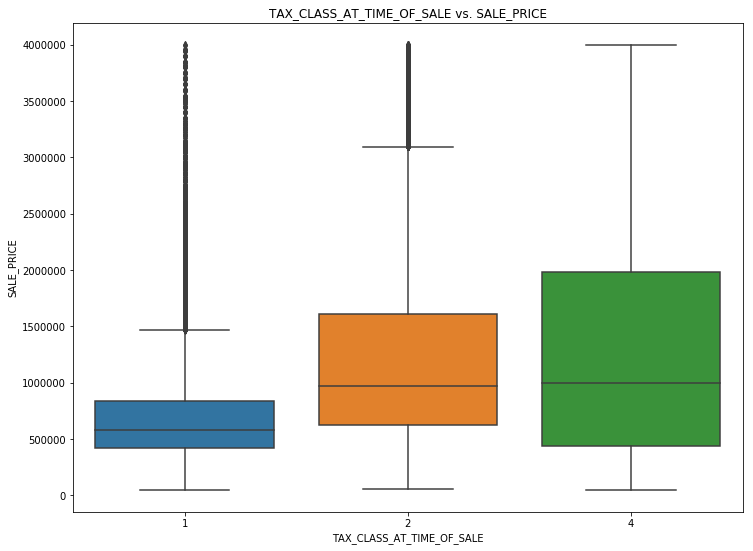

In [68]:
#Analyzing the statistics for TAX_CLASS_AT_TIME_OF_SALE

plt.figure(figsize = (12, 9))
sns.boxplot(x = tc, y = sp, data = nyc_df)
plt.title('TAX_CLASS_AT_TIME_OF_SALE vs. SALE_PRICE')

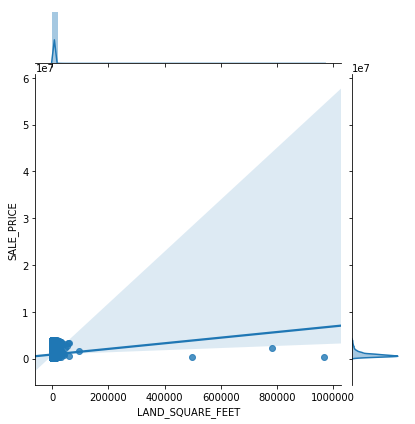

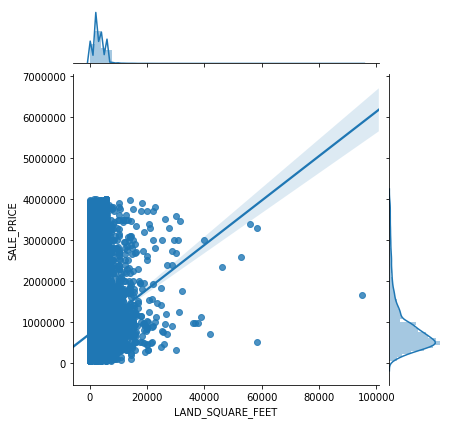

In [69]:
#Analyzing the statistics for LAND_SQUARE_FEET, looks fine

sns.jointplot(x = nyc_df[lsf], y = nyc_df[sp], kind = 'reg')

nyc_df = nyc_df[nyc_df[lsf] < 200000]

sns.jointplot(x = nyc_df[lsf], y = nyc_df[sp], kind = 'reg')

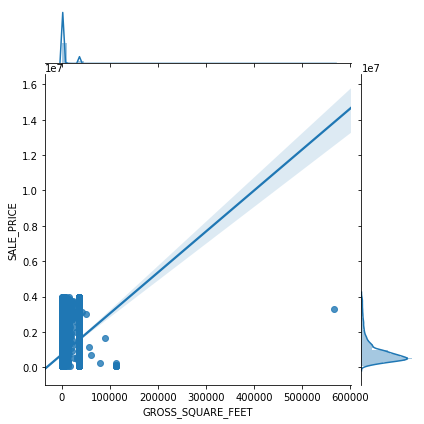

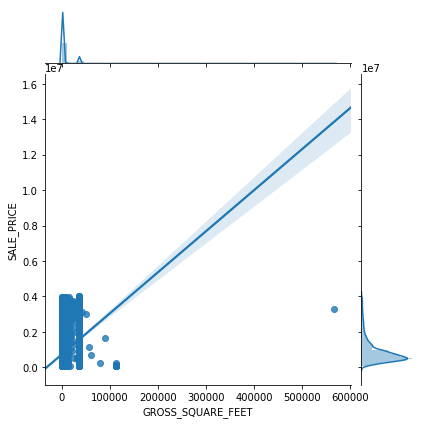

In [70]:
#Analyzing the statistics for GROSS_SQUARE_FEET, looks fine

sns.jointplot(x = nyc_df[gsf], y = nyc_df[sp], kind = 'reg')

nyc_df = nyc_df[nyc_df[lsf] < 200000]

sns.jointplot(x = nyc_df[gsf], y = nyc_df[sp], kind = 'reg')

In [92]:
#Just like we did for SALE_PRICE, we should also transform our numerical feature data

numerical_features = nyc_df.select_dtypes(include = ['int64','float64']).columns

from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

#skewed_distr = nyc_df[numerical_features].apply(lambda x: skew(x.dropna().astype(float)))
#skewed_distr = skewed_distr[skewed_distr > 0.75]
#skewed_distr = skewed_distr.index
#nyc_df[skewed_distr] = np.log1p(nyc_df[skewed_distr])

#scaler = StandardScaler()
#scaler.fit(nyc_df[numerical_features])
#scaled_distr = scaler.transform(nyc_df[numerical_features])

#for i, col in enumerate(numerical_features):
#       nyc_df[col] = scaled_distr[:,i]

#nyc_df

In [93]:
#nyc_df_unknown.drop(['TOTAL_UNITS', 'SALE_PRICE'], axis = 1, inplace = True)
print(nyc_df_unknown.columns)

nyc_df_unknown.drop(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'], axis = 1, inplace = True)

print(nyc_df.columns)

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')
Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')


In [73]:
#Moving on to one-hot encoding, all the categorical features we have are one-hot encodable, and won't produce 
#any more than 40 more dummy variable features, each, which is not too bad

categorical_features = nyc_df.select_dtypes(include = ['object']).columns
categorical_features_unknown = nyc_df_unknown.select_dtypes(include = ['object']).columns

print(categorical_features)
print(categorical_features_unknown)

ohe = pd.get_dummies(nyc_df[categorical_features])
ohe_unknown = pd.get_dummies(nyc_df_unknown[categorical_features])
#ohe.info(verbose = True, memory_usage = True, null_counts = True)

#We have 184 columns, after performing one hot encoding
#429 after one hot encoding NEIGHBORS

nyc_ohe_df = nyc_df.drop(categorical_features, axis = 1)
nyc_ohe_df = pd.concat([nyc_ohe_df, ohe], axis = 1)

nyc_ohe_unknown_df = nyc_df_unknown.drop(categorical_features_unknown, axis = 1)
nyc_ohe_unknown_df = pd.concat([nyc_ohe_unknown_df, ohe_unknown], axis = 1)

#nyc_ohe_df.info()




Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'],
      dtype='object')
Index(['SALE_PRICE'], dtype='object')


KeyError: "Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',\n       'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'],\n      dtype='object') not in index"

In [74]:
#Finally split the data into training/testing datasets

X_df = nyc_ohe_df.drop(sp, axis = 1)
Y_df = nyc_ohe_df[sp]

from sklearn.model_selection import KFold, train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_df, Y_df, test_size = .25, random_state = 42)

#y_test.shape

In [94]:
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

def rmse(y_test, y_hat):
    return np.sqrt(mean_squared_error(y_test, y_hat))

linreg = LinearRegression()
linreg.fit(x_train, y_train)
y_hat_linreg = linreg.predict(x_test)

#indices = abs(y_hat_linreg) > 5
#y_hat_linreg = y_hat_linreg[indices]
#y_test = y_test[indices]    
#print('Indices operation')

with open("linreg_output_normalized.txt", "w") as text_file:
    for i in range(len(y_hat_linreg)):
        data_line = str(i) + ' ' + str(y_test.iloc[i]) + ' ' + str(y_hat_linreg[i]) + ' ' + str(rmse(y_test.iloc[:i+1], y_hat_linreg[:i+1])) + '\n'
        text_file.write(data_line)

rmse_linreg = rmse(y_test, y_hat_linreg)
mae_linreg = mean_absolute_error(y_test, y_hat_linreg)

print(rmse_linreg)
print(mae_linreg)

#print(rmse(y_test, y_hat_linreg) / (maximum - minimum))
#print(rmse(y_test, y_hat_linreg) / mean)

6238171857.829906
91266922.7925062


In [32]:
#Lasso regression model

lasso_regr = Lasso(alpha= .005, max_iter=50000)
lasso_regr.fit(x_train, y_train)
y_hat_lasso=lasso_regr.predict(x_test)
rmse_lasso = rmse(y_test, y_hat_lasso)
mae_lasso = mean_absolute_error(y_test, y_hat_lasso)

print(rmse_lasso)
print(mae_lasso)

0.7944701871502751
0.5974563576111666


In [22]:
#Ridge regression

ridge = Ridge(alpha=0.005, normalize=True)
ridge.fit(x_train, y_train)
y_hat_ridge = ridge.predict(x_test)
rmse_ridge = rmse(y_test,y_hat_ridge)
mae_ridge = mean_absolute_error(y_test, y_hat_ridge)

print(rmse_ridge)
print(mae_ridge)

0.6627394818692044
0.4681337875864185


In [34]:
#Random Forest Regression model

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_hat_rf = rf.predict(x_test)
rmse_random_forest = rmse(y_test,y_hat_rf)
mae_random_forest = mean_absolute_error(y_test, y_hat_rf)

with open("rf_output_normalized.txt", "w") as text_file:
    for i in range(len(y_hat_linreg)):
        data_line = str(i) + ' ' + str(y_test.iloc[i]) + ' ' + str(y_hat_rf[i]) + ' ' + str(rmse(y_test.iloc[:i+1], y_hat_rf[:i+1])) + '\n'
        text_file.write(data_line)

print(rmse_random_forest)
print(mae_random_forest)



0.6373289314457422
0.43511642623839913


In [123]:
nyc_df.columns

nyc_df_2 = nyc_df

nyc_df_2.columns


#nyc_df_2.drop(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'SALE_DATE'], axis = 1, inplace = True)

x = nyc_df_2.drop(['SALE_PRICE'], axis = 1).values
#print(x)
y = nyc_df_2['SALE_PRICE']

rf_2 = RandomForestRegressor()
rf_2.fit(x, y)

y_hat_rf_2 = rf_2.predict(nyc_df_unknown.drop(['SALE_PRICE'], axis = 1))

indices = nyc_df_unknown.index
print(indices)

len(indices)

with open("rf_output_unknown.txt", "w") as text_file:
    for i in range(len(y_hat_rf_2)):
        data_line = str(indices[i]) + ' ' + str(y_hat_rf_2[i]) + '\n'
        text_file.write(data_line)

    
#    for i in 
#    text_file.write(np.array_str(y_hat_rf_2))
    
#nyc_df_unknown

Int64Index([    1,     2,     5,     7,     8,    10,    77,    78,    82,
               83,
            ...
            84507, 84509, 84513, 84515, 84523, 84524, 84525, 84538, 84539,
            84542],
           dtype='int64', length=12082)


ValueError: Number of features of the model must match the input. Model n_features is 422 and input n_features is 344 

In [24]:
#Elastic Net model w/ alpha of .005

from sklearn.linear_model import ElasticNet

en = ElasticNet(random_state = 42, alpha = .005)

en.fit(x_train, y_train)

y_hat_en = en.predict(x_test)

rmse_en = rmse(y_test, y_hat_en)
mae_en = mean_absolute_error(y_test, y_hat_en)

print(rmse_en)
print(mae_en)

0.7690233832812127
0.5725677112639946


In [ ]:
linreg_scores = cross_val_score(LinearRegression(), X_df, Y_df, cv = 5)
print('Linear Regression:', linreg_scores, np.mean(abs(linreg_scores)))

ridge_scores = cross_val_score(Ridge(alpha=0.01, normalize=True), X_df, Y_df, cv = 5)
print('Ridge:', ridge_scores, np.mean(abs(ridge_scores)))

en_scores = cross_val_score(ElasticNet(random_state = 42, alpha = .01), X_df, Y_df, cv = 5)
print('Elastic Net:', en_scores, np.mean(abs(en_scores)))

rf_scores = cross_val_score(RandomForestRegressor(), X_df, Y_df, cv = 5)
print('Random Forest:', rf_scores, np.mean(abs(rf_scores)))

lasso_scores = cross_val_score(Lasso(alpha= .01, max_iter=50000), X_df, Y_df, cv = 5)
print('Lasso:', lasso_scores, np.mean(abs(lasso_scores)))

Linear Regression: [-3.78063595e+12 -4.16233891e+13 -3.79275184e+14 -3.02972120e+12
 -8.88332697e+00] 85541786091940.06
Ridge: [-0.43142075  0.0725188   0.05989782 -0.13372349 -4.92764174] 1.1250405208318384
Elastic Net: [-0.95565291  0.13894121  0.13801539  0.14475766 -1.29072873] 0.533619182135914
Random Forest: [-0.07256002  0.15332812  0.13175886  0.18419876 -0.37367897] 0.18310494518645887


In [18]:
#Bar graph showing 4 different models' errors

Linear Regression: [ 0.0312277   0.15988961 -2.86921426] 1.0201105256712923
Ridge: [ 0.14576369  0.16205727 -1.7032096 ] 0.6703435182588807
Elastic Net: [-0.19753859  0.17090257 -0.66726946] 0.34523687060642355
Random Forest: [ 0.29509538  0.21607096 -2.29907636] 0.9367475657141977
Lasso: [ 0.12293743  0.15920738 -2.90125794] 1.061134250449264


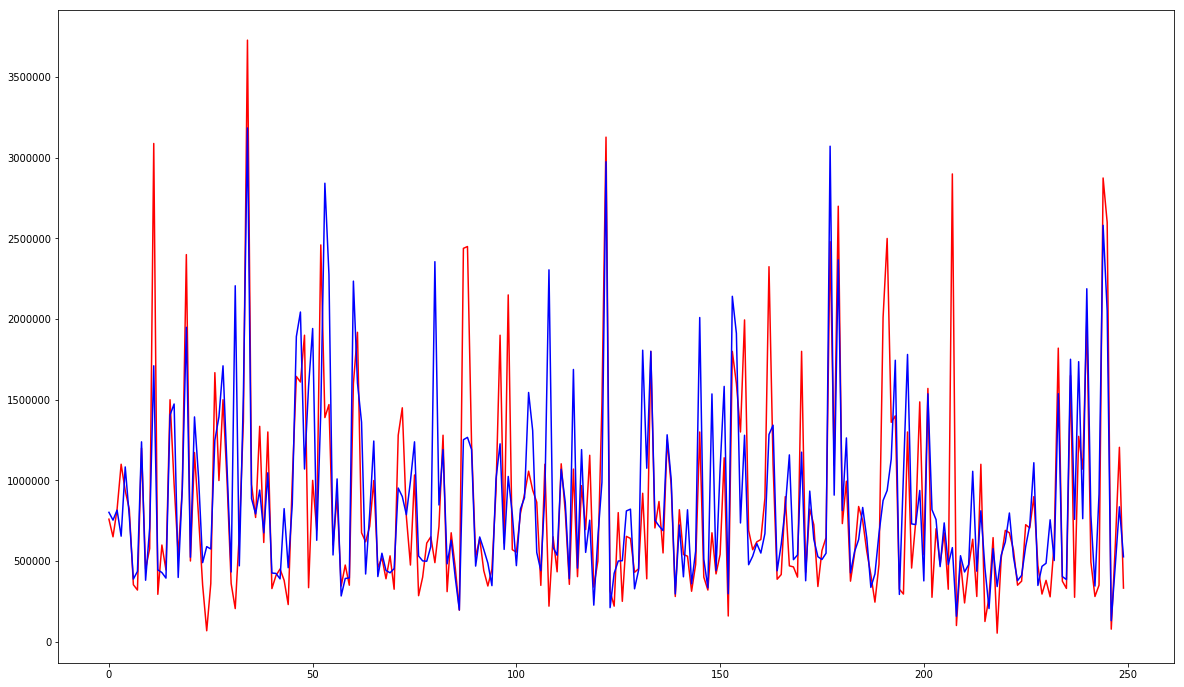

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 12))

plt.plot(y_test.values[:250], color= 'red', label = 'Real Price')
plt.plot(y_hat_rf[:250], color = 'blue', label = 'Predicted Price')

In [44]:
len(X_df.columns)
#X_unknown_df = nyc_ohe_unknown_df.drop(sp, axis = 1)

422